# $\nabla v_{LSR}$ in HC$_3$N

We calculate the gradient in velocities $v_{LSR}$ adn then visualize it with line integral convolution (LIC). 

For this, we calculate the gradient in a plane around a radius of approx 2 beam sizes, to sample well resolved structures.

In [1]:
import numpy as np
import scipy.linalg # we only fit a linear plane so we go with easy linear code
from astropy.io import fits
import astropy.units as u
import sys
sys.path.append('../')
from B5setup import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gaussfitfolder = 'gaussfit/'
velfile = gaussfitfolder + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Vlsr'
Tpeakfile = gaussfitfolder + 'B5-NOEMA+30m-H3CN-10-9_cut_K_1G_fitparams_filtered_Tpeak'
nablavelfile = velfile + '_gradient'
epsilon = 1e-3 # tolerance to mask values
# values for LIC
nbeams = 2
nbeams_kernel = 10

In [3]:
# we need to sample an area of about 2 beams in principle
# we can try for different sample radii
velfield, velheader = fits.getdata(velfile+'.fits', header=True)
y_velfield, x_velfield = np.mgrid[:len(velfield), :len(velfield[0])]
beammaj, beammin = velheader['BMAJ'], velheader['BMIN']
pixsize_deg = np.abs(velheader['CDELT2'])
pixsize_pc = (pixsize_deg * 3600 * dist_B5.value * u.au).to(u.pc).value # this is pixel to pc
equivradius = np.sqrt(beammaj * beammin / (4 * np.log(2)))
sampleradius = int(np.round(nbeams* equivradius / pixsize_deg, 0))
beamarea_pix = np.pi * beammaj * beammin / (4 * np.log(2) * pixsize_deg**2)

In [4]:
filled_indices = np.where(~np.isnan(velfield))
nablax_map = np.ones(np.shape(velfield)) * np.nan
nablay_map = np.ones(np.shape(velfield)) * np.nan

In [5]:
for y, x in np.transpose(filled_indices):
    sampleregion = velfield[y-sampleradius:y+sampleradius+1, x-sampleradius:x+sampleradius+1]
    if np.shape(sampleregion)[0] != np.shape(sampleregion)[1]: 
        continue
    elif np.sum(~np.isnan(sampleregion))<beamarea_pix: 
        continue
    X,Y = np.meshgrid(np.arange(-sampleradius, sampleradius+1, 1), np.arange(-sampleradius, sampleradius+1, 1))
    # XX = X.flatten()
    # YY = Y.flatten()
    # sampleradius+1 will be the center
    index_sampleregion_filter = np.where(distancepix(X, Y, sampleradius+1, sampleradius+1)<sampleradius * ~np.isnan(sampleregion))
    data_sample = np.transpose([X[index_sampleregion_filter]*pixsize_pc, Y[index_sampleregion_filter]*pixsize_pc, sampleregion[index_sampleregion_filter]])
    # data_sample_filtered = data_sample[:, ~np.isnan(data_sample[:, 2])]
    A = np.c_[data_sample[:,0],data_sample[:,1], np.ones(data_sample.shape[0])] 
    C,_,_,_ = scipy.linalg.lstsq(A, data_sample[:,2])
    if np.abs(C[0])< epsilon or np.abs(C[1])< epsilon: continue
    nablax_map[y, x] = C[0] 
    nablay_map[y, x] = C[1] 
    
    # we need to get the gradient in km/s/pc

In [6]:
gradheader = velheader.copy()
gradheader['BUNIT'] = 'km s-1 pc-1'

fits.writeto('gradient_x_{0}beams.fits'.format(nbeams), nablax_map, gradheader, overwrite=True)
fits.writeto('gradient_y_{0}beams.fits'.format(nbeams), nablay_map, velheader, overwrite=True)

## LIC visualization

Check the edges, they may make too much noise in the vector map


In [7]:
import lic_internal

In [8]:

texture = np.random.rand(len(velfield), len(velfield[0])).astype(np.float32)
kernellen = int(np.round(nbeams_kernel* equivradius / pixsize_deg, 0))
kernel = np.sin(np.arange(kernellen)*np.pi/kernellen).astype(np.float32)

vectors = np.transpose([nablay_map, nablax_map]) 

In [9]:
vectors = vectors.astype(np.float32)

image = np.transpose(lic_internal.line_integral_convolution(vectors, texture, kernel))
image[np.where(np.isnan(nablax_map))] = 0

In [10]:
tpeakmap = fits.getdata(Tpeakfile+'.fits')

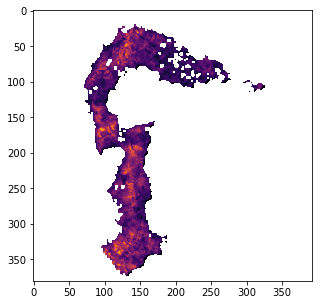

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# ax.imshow(tpeakmap, cmap='inferno')
# ax.imshow(image, cmap='Greys', alpha=0.5)
ax.imshow(image * tpeakmap, cmap='inferno')
fig.savefig('gradient_map_LIC_{0}beams_{1}beamkernel.pdf'.format(nbeams, nbeams_kernel), bbox_inches='tight')

In [12]:
dpi=300
size = len(velfield)*10

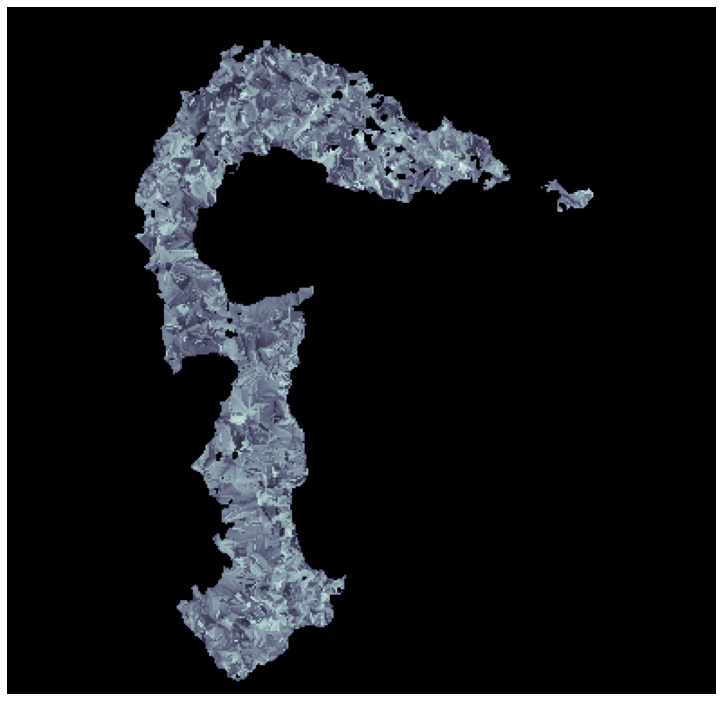

In [13]:
plt.clf()
plt.bone()
plt.axis('off')
plt.imshow(image)
plt.gcf().set_size_inches((size/float(dpi),size/float(dpi)))
plt.savefig("flow-image_{0}beams_{1}beamkernel.png".format(nbeams, nbeams_kernel),dpi=dpi)